In [110]:
import configparser

parser = configparser.ConfigParser()
parser.read('config.ini')

['config.ini']

# libs & formatting 

In [181]:
import sys
import pandas as pd
import numpy as np
import os
import traceback
import pdb
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
import json
np.seterr(all="ignore")

#--- user libs
sys.path.append(parser['py library directory']['path'])
import utility as utl
import imp
imp.reload(utl)
import LammpsPostProcess2nd as lp
imp.reload(lp)

class Symbols:
    def __init__(self,
                markersizes=[10,10,10,12,12,12,10],
                ):
        self.colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
        self.fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
        self.markers=['o','s','D','^','<','>','v']
        self.markersizes=markersizes
        self.nmax=7
        
    def GetAttrs(self,count=0,label='',nevery=1,fmt='.-',zorder=1,alpha=1):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':self.colors[count],
            'markeredgecolor':'white', #'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
             'zorder':zorder,
               'alpha':alpha
         }
        return attrs
    
    def GetAttrs2nd(self,count=0,label='',nevery=1,fmt='.-',zorder=1):
        '''
        empty symbols
        '''
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':'white',
#            'markeredgecolor':'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
            'zorder':zorder,
          }
        return attrs

    def GetAttrsScatter(self,count=0,label='',nevery=1,fmt='.-',zorder=1,alpha=0.5):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            's':self.markersizes[count],
            'marker':self.markers[count],
#            'edgecolors':'white', #'black' if not self.fillstyles[count] else None,
            'label':label,
            'linewidth':1, 
             'zorder':zorder,
               'alpha':alpha
         }
        return attrs
    
    
class Legends:
    def __init__(self
                ):
        pass
    def Set(self,fontsize=20,
                 labelspacing=0,
                 **kwargs
#                 bbox_to_anchor=(0.5,0.48,0.5,0.5),
           ):
        self.attrs = {'frameon':False,'fontsize':fontsize,
                   'labelspacing':labelspacing,
                      'handletextpad':.2,
                   'handlelength':1,
                    **kwargs,
                     }
    def Get(self):
        return self.attrs
    
DRAW_FRAME=(0.23,0.08,0.12,0.07,0.1)
if not eval(parser['flags']['RemoteMachine']):
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!


# Avalanche statistics
## class Statistics

In [3]:
class Statistics:
    
    def __init__(self,path,verbose=False):

        self.path = path
        self.verbose = verbose
        
        #--- list of files
        self.inputFiles = os.listdir('%s'%(path))
        if self.verbose:
            print('inputFiles=',np.array(self.inputFiles))
            
            
    def ParseDump(self,fp):
        if self.verbose:
            print('parsing %s/%s:'%(self.path,fp))
        self.lmpData = lp.ReadDumpFile('%s/%s'%(self.path,fp)) #,verbose=self.verbose)
        self.lmpData.GetCords(ncount=sys.maxsize)
        #--- print
        if self.verbose:
            keys = list(self.lmpData.coord_atoms_broken.keys())
            keys.sort()
            display(self.lmpData.coord_atoms_broken[keys[0]])
    
    def ParseTimeSeries(self,fp,cols=['strain','press','szz','sxx','syy','sxy','syz','sxz','vol']):    
        #--- read input file
        # loadTimeSeries=list(map(lambda x:pd.DataFrame(np.c_[np.loadtxt('%s/%s'%(path,x))],
        #                 columns=['Time','Stress']),inputFiles))
        # loadTimeSeries[0] #--- index indicates the indenter location

        self.loadTimeSeries=pd.DataFrame(np.c_[np.loadtxt('%s/%s'%(self.path,fp),max_rows=1000000)],
                        columns=cols,
                                   )
    def PltTimeSeries(self):
        !mkdir png

        #--- set limits
#        index = 0 #--- file index
        ld = self.loadTimeSeries #[ index ] #--- file id
        # indentLabel, grainID = GetGrainId(indent,indentLabels,loadID,index)
        # print('indent label:%s, grain id:%s'%(indentLabel,grainID))

        #--- time
        tlo = ld.strain.min()
        thi = ld.strain.max() #ld.Time.max()
        filtr=np.all([ld['strain']<thi,ld['strain']>=tlo],axis=0)
        # #--- load
        flo = 0.99*ld['szz'][filtr].min()
        fhi = 1.01*ld['szz'][filtr].max() #ld.Force.max()

        #--- rate
        rate = -np.gradient(ld.szz,ld.strain)
        filtr = rate > 0


        ax=utl.PltErr(None,None,Plot=False)

        utl.PltErr(ld.strain[filtr], rate[filtr],
                   attrs={'fmt':'.','color':'red','ms':.4},
                    Plot=False,
                      ax=ax,
        #           yscale='log',
                    xlim=(tlo,thi),
#                    ylim=(0,3e4),

                  )

        #--- load vs. time
        utl.PltErr(ld.strain, ld.szz,
                   attrs={'fmt':'-','color':'C0'},
        #             Plot=False,
                    xlim=(tlo,thi),
                    ylim=(flo,fhi),
                   ax=ax,
                      twinx=True,
                    title='png/stress_timeseries.png',
                   DrawFrame=DRAW_FRAME,
                  )
    @staticmethod
    def GetAvl( t,x, y, lambdc ):
        n = len(x)
        i = 0
        smat = [[],[],[],[],[]]
        try:
            while True:
                while y[i] < lambdc:
                    i += 1
                assert y[i] >= lambdc
                #--- avalanche starts
                dur = 0
    #            size = 0.0 #y[i]
                start = x[i]
                start_indx = i
                start_t = t[i]
                while y[i]>=lambdc: #-x[i] == 1:
                    dur += 1
    #                size += (y[i]-lambdc)
                    i += 1
                #--- avalanche ends
                assert y[i] < lambdc
                end = x[i] #x[i-1 if i-1 >= 0 else 0]
                end_indx = i #i-1 if i-1>= 0 else 0
                end_t = t[i] #i-1 if i-1>= 0 else 0
                #--- size
                sub_x = x[start_indx:end_indx+1]
                sub_y = y[start_indx:end_indx+1]
                size = np.sum((sub_x[1:]-sub_x[:-1])*sub_y[:-1])
    #            print start, end, size
                #--- find epicenter
                smat = np.c_[smat,[start, end, start_t, end_t, size]]
        except:
    #        traceback.print_exc()
            pass

        assert smat.shape[1] > 0, 'Lower lambdc! lambdc='%lambdc
        df_avl = pd.DataFrame(smat.T,columns=['ei','ef','ti','tf','size'])
        df_avl=df_avl[df_avl['size']>0]
        return df_avl
    
    @staticmethod
    def Wrapper_GetAvl(t,x,y,tlo,thi,lambdc):
        '''
        return avalanche sizes given force timeseries and initial and final times
        '''

    #    print(np.min(GetPower(ld,tlo,thi)))

        #--- data frame storing avalanche attributes
        filtr = np.all([x>tlo,x<thi],axis=0)

        df_avl = Statistics.GetAvl( t,np.array(x[filtr]), -np.gradient(y,x)[filtr], lambdc)
        print('# of avalanches:%s'%df_avl.shape[0])
        #df_avl = GetAvalKunMethod( broken_bonds,  5) #tcrltn )

        #--- save
        # df_fltrd = DataFrameSubSet( df_avl, #--- filter
        #                               'ti', 
        #                               ( 0, tavl ) ) 
        # df_fltrd.to_pickle('df_avl.pk')

        df_avl.sort_values( by = 'size',ascending = False,inplace=True)
    #    print ('n.avls = %s'%len(df_avl))
        return df_avl #np.array(df_avl['size'].to_list())

    def Avalanche(self,    
        lambdc = 0.0, #--- threshold
    #    temps=['900'] #'300','700','900','600','800']
        #tlo = 0.0
        #thi = dmpStrs.strain.max()
                 ):
        tlo = self.loadTimeSeries.strain.min()
        thi = self.loadTimeSeries.strain.max()
                

        try:
            df_avl = list(map(lambda x:Statistics.Wrapper_GetAvl(list(x.index),x.strain,x.szz,tlo,thi,lambdc),\
                              [self.loadTimeSeries]))
        #    df_avl = dict(zip(temps,list(map(lambda x:Wrapper_GetAvl(x.timestep,x.strain,x.szz,tlo,thi,lambdc), [dmpStrs]))))
        #    print('df_avl.shape:%s'%df_avl['300'].shape[0])
        #    df_avl = Wrapper_GetAvl(ld,tlo,thi,lambdc)
        except:
            traceback.print_exc()
            print('increase the threshold')


        self.df_avl = df_avl[0]
#        symbols=Symbols()
        
        #--- plot stress timeseries
#         ax=utl.PltErr(self.loadTimeSeries.strain,self.loadTimeSeries.szz,#dmpStrs.strain,dmpStrs.szz,
#         #            attrs=symbols.GetAttrs(count=0),
#                       Plot=False,
#                     xlim=(tlo,thi),
#                   )
        
        #--- plot stress drops
#         utl.PltErr(self.df_avl['ef'],self.df_avl['size'],
#                    attrs={'fmt':'x','color':'red'},
#                      xlim=(tlo,thi),
#         #            ylim=(flo,fhi),
#                    ax=ax.twinx(),
# #                    yscale='log',
#                    DrawFrame=DRAW_FRAME,
#                    title='png/size.png'
#                   )

    def SizeDist(self,sizes, fout, **kwargs):
#         ax = utl.PltErr(None,None,Plot=False)
#         symbols=Symbols()
#         legend=Legends()
#         legend.Set(fontsize=20,
#                          labelspacing=0,
#                          bbox_to_anchor=(.9,0.48,0.5,0.5),
#                    )

        alpha=1.0
        count=0
        temp='900'
    #    for count,temp in zip(range(len(df_avl)),['900']): #--- different temperatures
#        sizes = self.df_avl['size']
        smax = np.max(sizes)
        hist, edge, err = utl.GetPDF(sizes, n_per_decade=6, linscale=None)
        
        with open('avlStats/%s'%fout,'w') as fp:
            np.savetxt(fp,np.c_[hist, edge, err],header='hist edge err')
        if self.verbose:
            print('write in %s'%fout)
        
#         utl.PltErr(edge, 
#                    10**count*hist,#*edge**alpha, 
#                    yerr=10**count*err,#*edge**alpha,
#                    Plot=False,ax=ax,
#                    attrs=symbols.GetAttrs(count=count),#,label=r'$%s$'%temp),
#                   )

#         utl.PltErr(None, None,
#                    ax=ax,
#                    **kwargs,
#                    DrawFrame=DRAW_FRAME,
#                    #legend=legend.Get()
#                   )
    
    def Scatter(self,x,y,fout,**kwargs):
#         symbols=Symbols()
#         utl.PltErr(x,
#                    y,
#                   attrs= symbols.GetAttrs(count=0,fmt='.'),
#                    DrawFrame=DRAW_FRAME,
#                    **kwargs,
#                   )
        with open('avlStats/%s'%fout,'w') as fp:
            np.savetxt(fp,np.c_[x, y],header='size duration')

def main():
    !mkdir avlStats
    
    #--- call constructor
    stats = Statistics(path = parser['test data directory']['path'],verbose=True)

    #--- parse dump file
    #stats.ParseDump(fp='atoms.dump')

    #--- parse timeseries
    stats.ParseTimeSeries(fp='thermo.txt',
#                         cols=['strain','szz'], #--- comment for different rates
                         )

    #--- plot timeseries
    if not eval(parser['flags']['RemoteMachine']):
        stats.PltTimeSeries()

    #--- get avalanches
    stats.Avalanche()

    #--- size distribution
    stats.SizeDist(sizes=stats.df_avl['size'],
                   fout='pdf_s.txt',
#                         attrs={'fmt':'-.r'},
#                        xscale = 'log',
#                        yscale='log',
            #           xlim=(1.0e-6,.2),
            #           ylim=(1e-1,1e8),,
#                       title='png/ps.png',
    )

    #--- duration
    stats.SizeDist(sizes = stats.df_avl['ef']-stats.df_avl['ei'],
                   fout='pdf_dur.txt',
                        attrs={'fmt':'-.r'},
#                        xscale = 'log',
#                        yscale='log',
            #           xlim=(1.0e-6,.2),
            #           ylim=(1e-1,1e8),,
#                       title='png/pt.png',
                  )

    #--- size vs. duration
    stats.Scatter(stats.df_avl['ef']-stats.df_avl['ei'],
                 stats.df_avl['size'],
                  fout='scatter_st.txt',
                  xscale='log',yscale='log',
                       title='png/scatter_st.png',

                 )
    
main()

mkdir: avlStats: File exists
inputFiles= ['junk.dump']


OSError: ../testdata/aedata/cantor/rateT900K/rate1/Run0/thermo.txt not found.

## class Temperature

mkdir: png: File exists
[[4 0]
 [1 0]
 [2 0]
 [3 0]]
Parsing: data.shape is (23006, 2)
Parsing: data.shape is (22941, 2)
Parsing: data.shape is (23294, 2)
Parsing: data.shape is (23322, 2)


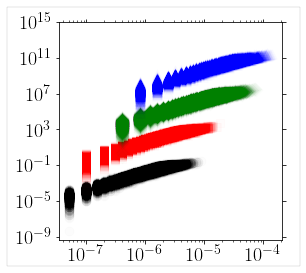

In [233]:
class Temperature:
    
    def __init__(self,temp_range,nrun,verbose=False):
        self.temps =  temp_range
        self.nrun = nrun
        t,r=np.meshgrid(self.temps,np.arange(nrun),indexing='ij')
        self.temps_runs = np.array(list(zip(t.flatten(),r.flatten())))
        self.verbose = verbose
        
    def Parse(self,dirs):
#         print('dirs:',dirs)
        self.data=list(map(lambda x:np.loadtxt(x,ndmin=2),dirs))
        if self.verbose:
            list(map(lambda x:print('Parsing: data.shape is',x.shape),self.data))
#        print('np.array(self.data):',np.array(self.data))

        
    def PlotScatter(self,shift = False,  mylegends='',**kwargs):
#        print(list(self.temps_runs))
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)

        symbols=Symbols(markersizes=np.array([10,10,10,12,12,12,10])*8)
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs
                    else (1.0,0.5,0.5,0.5)
                   )
        for data, temp_run, count in zip(self.data,self.temps_runs,range(len(self.data))): 
            temp = temp_run[0]
            text = mylegends[count] if not mylegends == '' else ' '
            #
            xdata = data[:,0]
            ydata = data[:,1]
            ydata = ydata*1e4**count if shift else ydata

            self.ax.scatter(xdata,ydata,
                        **symbols.GetAttrsScatter(count=count%7,label='%s'%text,fmt='.',alpha=0.01),
                       )
        #
        attrs = {} if mylegends == '' else {'legend':legends.Get()}
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,
                   DrawFrame=DRAW_FRAME,
                   **attrs,
                   **kwargs
                  )
    def PlotPdf(self,shift = False,mylegends='', **kwargs):
#        print(list(self.temps_runs))
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)

        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs
                    else (1.0,0.5,0.5,0.5)
                   )
        for data, temp_run, count in zip(self.data,self.temps_runs,range(len(self.data))): 
            temp = temp_run[ 0 ]
            text = mylegends[count] if not mylegends == '' else ' '
            #
            xdata = data[ :,1 ]
            ydata = data[ :,0 ]
            yerr  = data[:,2]
            #
            ydata = ydata*100**count if shift else ydata
            yerr  = yerr*100**count if shift else yerr

            try:
                utl.PltErr(xdata,ydata,
                        yerr=yerr,
                       ax = self.ax,
                       attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%text),
                       Plot=False,
                      )
            except:
                continue
        #
        attrs = {} if mylegends == '' else {'legend':legends.Get()}
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,
                   DrawFrame=DRAW_FRAME,
                   **attrs,
                   **kwargs
                  )
        
    def EnsAverage(self,log_scale=False,n_bins_per_decade=6):
        kount = 0
        self.data_averaged = {} #np.zeros(len(self.temps))
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            data = self.data[kount:kount+self.nrun]
            if self.verbose:
                print('data.shape:',np.array(data).shape)
#             print('np.array(data):',np.array(data))
#             pdb.set_trace()
    
            filtr = list(map(lambda x:x.shape[0] > 0,data)) #--- filter empty arrays
    
            data = np.concatenate(np.array(data)[filtr]) #,axis=0)
            self.data_averaged[ temp ] = self.hist(data,log_scale,n_bins_per_decade=n_bins_per_decade)
            kount += self.nrun

    def hist(self,data,log_scale,n_bins_per_decade=6):
        n_thresh = 2
            #--- average
        xdata = data[:,0]
        ydata = data[:,1]
        xmin = np.floor(np.log10(xdata).min())
        xmax = np.ceil(np.log10(xdata).max())
        n_decades = int((xmax - xmin))
        bins = np.logspace(xmin,xmax,n_decades*n_bins_per_decade)
        #
        count, _ = np.histogram(xdata,bins=bins)
        xsum, _  = np.histogram(xdata,bins=bins,weights=xdata)
        weights = ydata if not log_scale else np.log10(ydata)
        ysum, _  = np.histogram(xdata,bins=bins,weights=weights)
        ysum_sq, _  = np.histogram(xdata,bins=bins,weights=weights*weights)
        #
        xsum = xsum[count>n_thresh]
        ysum = ysum[count>n_thresh]
        ysum_sq = ysum_sq[count>n_thresh]
        count = count[count>n_thresh]
        #
        xsum /= count
        ysum /= count
        ysum_sq /= count
        std = np.sqrt((ysum_sq - ysum * ysum)/count)
        if log_scale:
            ysum = 10 ** ysum
            std = 0.5 * ysum * (1+2*std*np.log(10))
        return np.c_[xsum,ysum,std]
        
        
#            utl.PltErr(xsum,ysum,ax=self.ax)
            

    def PlotAverage(self,rescale=False,**kwargs):
#        print(list(self.temps_runs))
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)

        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs
                    else (1.0,0.5,0.5,0.5))
        for temp, count in zip(self.temps,range(len(self.temps))): 
            data = self.data_averaged[ temp ]
            xdata = data[:,0]
            ydata = data[:,1]
            yerr = data[:,2]
            if rescale:
                ydata /= xdata
                yerr /= xdata
            utl.PltErr(xdata,ydata,
                   yerr=yerr,
                   ax = self.ax,
                   attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%temp,nevery=1),
                   Plot=False,
                  )

        utl.PltErr(None,
                   None, 
                   ax=self.ax,
                   Plot=False,
#                    legend=legends.Get(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )
        
        
    def func2nd(self,x,y0,c0,alpha):
#        return y0+c0*(x/x0)**alpha
        return y0+c0*x**alpha
#     def func2nd(self,x,y0,m0):
#         return y0+m0*x

    def Fit(self,Plot=None,
            shift = False,
#             SIGMA=False,
            plotAttrs=None,
            bounds=(-np.inf, np.inf),
            xlo=float('-inf'),xhi=float('inf'),
            **kwargs):
        self.Diffusion = {}
        self.exponent = {}
        pref=1e-10*1e-10 #--- ang^2 to m^2
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=plotAttrs['bbox_to_anchor'] if 'bbox_to_anchor' in plotAttrs
                    else (1.0,0.5,0.5,0.5))

        if Plot:
            ax = utl.PltErr(None,None,
                            Plot=False)
        #
        for temp, count in zip(self.temps,range(len(self.temps))): 
            self.smat = smat = self.data_averaged[ temp ] if self.nrun > 1 else self.data[count]

            xdata=smat[:,0]
            ydata=smat[:,1]
            yerr = smat[:,2]
#             print(smat)

        
            #--- set limits:
            if self.verbose:
                print('limits:',xlo,xhi)

            filtr = np.ones(xdata.shape[0],dtype=bool)
            filtr = np.all([filtr,xdata > xlo],axis=0)
            filtr = np.all([filtr,xdata <= xhi],axis=0)
            assert np.any(filtr), 'empty arrays!'
            if self.verbose:
                print('filtr=',filtr)
            
            #--- error in y
            if 'sigma' in kwargs:
                kwargs['sigma'] = 2*yerr[filtr]

            #--- fit
#             print(kwargs)
            popt, pcov = curve_fit(self.func2nd, xdata[filtr], ydata[filtr],
                                   bounds=bounds, #([1e-1, 1e5,0.5], [1e0, 1e7,2.0]), #[(4e-3, 1e5,0.5), (1e-2, 1e7,2.0)],#bounds,
                                    **kwargs
                                    )
            self.popt = popt
            self.filtr = filtr
            #--- uncertainties
            if self.verbose:
                print('Temp=%s,y0,c0,alpha'%temp,list(popt),pcov)
            y0=popt[0]
            alpha=popt[2]
            err_alpha = pcov[2,2]**0.5
            c0=popt[1]
            dc = pcov[1,1]**0.5
            tau=1#popt[0]
            dtau=0#pcov[0,0]**0.5
            self.time_scale = tau * (y0/c0)**(1/alpha)
#             self.Diffusion[temp] = [pref*c0/tau,pref*c0/tau,pref*c0/tau]
            self.Diffusion[temp] = [pref*c0/(tau)**alpha, pref*(c0+dc)/(tau-dtau)**alpha, 
                                    pref*(c0-dc)/(tau+dtau)**alpha]
            self.exponent[temp] = [alpha,alpha+err_alpha,alpha-err_alpha]
            if Plot:
                #---fit
                y0=0 #kam
                xdata_shift = xdata*20**count if shift else xdata
                utl.PltErr(xdata_shift,
                                (self.func2nd(xdata,*popt)-y0),#-y0)/xdata_shift,
                                attrs={'fmt':'-.','color':symbols.colors[count%7]},
                           Plot=False,ax=ax)
                #--- points
#                temp= [1000,1200,1400,1600,1800,2000][count]
                utl.PltErr(xdata_shift,
                           (ydata-y0),#-y0)/xdata_shift,
                           yerr=(yerr),#-y0),#/xdata_shift,
                           attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%temp,fmt='.'),
                           ax=ax,
                           Plot=False,
                          )
        if Plot:
            utl.PltErr(None,
                       None, 
                       ax=ax,
                       Plot=False,
                       legend=legends.Get(),
                       DrawFrame=DRAW_FRAME,
                       **plotAttrs
                      )

    def PlotDiff(self,**kwargs):
        symbols=utl.Symbols()
        utl.PltErr(1.0/np.array(self.temps),
                   list(map(lambda x:self.Diffusion[x][0],self.temps)),
                   yerr=list(map(lambda x:(self.Diffusion[x][1]-self.Diffusion[x][2])/2,self.temps)),
                   attrs=symbols.GetAttrs(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )

    def PlotExponent(self,**kwargs):
        symbols=utl.Symbols()
        ax=utl.PltErr([0.5e-3,1e-3],[1,1],attrs={'fmt':'-.r'},Plot=False)
        utl.PltErr(1.0/np.array(self.temps),
                   list(map(lambda x:self.exponent[x][0],self.temps)),
                   yerr=list(map(lambda x:1.0*(self.exponent[x][1]-self.exponent[x][2]),self.temps)),
                   attrs=symbols.GetAttrs(),
                   DrawFrame=DRAW_FRAME,
                   ax=ax,
                   **kwargs
                  )

def main():
    if eval(parser['flags']['RemoteMachine']):
        return
    
    !mkdir png
    #--- temp object
    temp = Temperature(
       [4,1,2,3],1,
#       [300,600,700,800,900],1,
#       [0],1,
         verbose = True,
                     )
    print(temp.temps_runs)
    #
    #--- parse data
    temp.Parse( 
#                ['avlStats/scatter_st.txt']
                list(map(lambda x:'tensileCantor_tensile900_rate%s/Run%s/avlStats/scatter_st.txt'%(x[0],x[1]),
#                list(map(lambda x:'tensileCantorT%sKRateE3/Run%s/avlStats/scatter_st.txt'%(x[0],x[1]),
                         temp.temps_runs ))
              )
#     #
#     #--- plot
    temp.PlotScatter(shift=True,
#                     mylegends=[r'$5\times 10^{7}$',r'$1\times 10^{8}$',r'$4\times10^{8}$',r'$8\times10^{8}$'],
#                     mylegends=[r'$300$',r'$600$',r'$700$',r'$800$',r'$900$'],
                     **{
                  'xscale':'log',
                  'yscale':'log',
#                   'xlim':(8e-6,2e-3),
#                    'ylim':(1e-15,1e19),
                    'ndecade_y':4,
                   'title':'png/scatter_st_E1-4.png',
#                   'title':'png/scatter_st_T300-900K.png',
        'bbox_to_anchor':(0.52,0.02,0.5,0.5)
    })


main()

### size pdf

mkdir: png: File exists
[[300   0]
 [600   0]
 [700   0]
 [800   0]
 [900   0]]
Parsing: data.shape is (40, 3)
Parsing: data.shape is (35, 3)
Parsing: data.shape is (37, 3)
Parsing: data.shape is (37, 3)
Parsing: data.shape is (39, 3)
single realizations


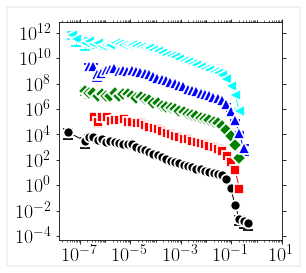

In [84]:
def main():
    if eval(parser['flags']['RemoteMachine']):
        return
    
    !mkdir png
    #--- temp object
    temp = Temperature(
#       [4,1,2,3],1,
       [300,600,700,800,900],1,
#       [0],1,
         verbose = True,
                     )
    print(temp.temps_runs)
    #
    #--- parse data
    temp.Parse( 
#                ['avlStats/scatter_st.txt']
#                list(map(lambda x:'tensileCantor_tensile900_rate%s/Run%s/avlStats/pdf_s.txt'%(x[0],x[1]),
                list(map(lambda x:'tensileCantorT%sKRateE3/Run%s/avlStats/pdf_s.txt'%(x[0],x[1]),
                         temp.temps_runs ))
              )
#     #
#     #--- plot
    print('single realizations')
    temp.PlotPdf(shift=True,**{
                  'xscale':'log',
                  'yscale':'log',
#                   'xlim':(1e-10,1e-3),
#                    'ylim':(1e-5,1e-1),
                    'ndecade_y':2,'ndecade_x':2,
                   'title':'png/pdf_s_T300-900K.png',
        'bbox_to_anchor':(0.01,0.3,0.5,0.5)
    })


main()

### duration

mkdir: png: File exists
[[4 0]
 [1 0]
 [2 0]
 [3 0]]
Parsing: data.shape is (13, 3)
Parsing: data.shape is (13, 3)
Parsing: data.shape is (13, 3)
Parsing: data.shape is (13, 3)


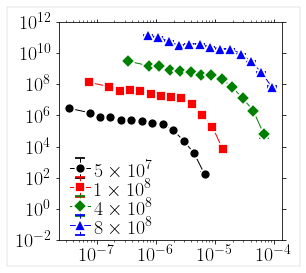

In [232]:
def main():
    if eval(parser['flags']['RemoteMachine']):
        return
    
    !mkdir png
    #--- temp object
    temp = Temperature(
       [4,1,2,3],1,
#       [300,600,700,800,900],1,
#       [0],1,
         verbose = True,
                     )
    print(temp.temps_runs)
    #
    temp.Parse( 
#                ['avlStats/scatter_st.txt']
                list(map(lambda x:'tensileCantor_tensile900_rate%s/Run%s/avlStats/pdf_dur.txt'%(x[0],x[1]),
#                list(map(lambda x:'tensileCantorT%sKRateE3/Run%s/avlStats/pdf_dur.txt'%(x[0],x[1]),
                         temp.temps_runs ))
              )

    #--- plot
    temp.PlotPdf(shift=True,
                     mylegends=[r'$5\times 10^{7}$',r'$1\times 10^{8}$',r'$4\times10^{8}$',r'$8\times10^{8}$'],
#                     mylegends=[r'$300$',r'$600$',r'$700$',r'$800$',r'$900$'],
                 **{
                  'xscale':'log',
                  'yscale':'log',
#                   'xlim':(1e-7,2e-2),
                    'ylim':(1e-2,1e12),
                    'ndecade_y':2,
                   'title':'png/pdf_dur_E1-4.png',
#                   'title':'png/pdf_dur_T300-900K.png',
        'bbox_to_anchor':(0,-0.05,0.5,0.5)
    })


main()

# Dislocation analysis

In [176]:
class Defects(Statistics):
    '''
    performs dislocation and phase analysis of input crystals
    '''
    StructureType=[0.0,1.0,2.0,3.0,4.0,5.0] #--- hard coded
    
    def __init__(self,path,verbose=False):
        Statistics.__init__(self,path,verbose)

        
    def CrysPhase(self,fp):
        '''
        dump phase information
        
        '''
        !mkdir -p dislocations/mydislocations
        #--- run ovitos
        input_file='%s/%s'%(self.path,fp)
        nevery = int(parser['dislocation analysis']['nevery'])
        os.system('ovitos %s/OvitosCna.py %s mydislocations %s 5'%\
                  (parser['py library directory']['path'],input_file,nevery))
        !mv mydislocations.* dislocations/mydislocations

    def ParseDump(self,fp):
        if self.verbose:
            print('parsing %s:'%(fp))
        self.lmpData = lp.ReadDumpFile('%s'%(fp)) #,verbose=self.verbose)
        self.lmpData.GetCords(ncount=sys.maxsize)
        #--- print
        if self.verbose:
            keys = list(self.lmpData.coord_atoms_broken.keys())
            keys.sort()
            display(self.lmpData.coord_atoms_broken[keys[0]])

    def Density(self,fout):
        keys = list(self.lmpData.coord_atoms_broken.keys())
        keys.sort()
        ratios = np.c_[list(map(lambda x:Defects.phaseDensity(self.lmpData.coord_atoms_broken[x]),keys))]
        strains = self.strains = Defects.Strain(self.lmpData)
        #--- write
        with open(fout,'w') as fp:
            np.savetxt(fp,np.c_[keys,strains,ratios],header='itime ezz other fcc hcp bcc cubicDiamond hexDiamond')

    def BinaryMatrix(self):
        '''
        returns a binary matrix of clusters
        '''
        !mkdir -p dislocations/BinaryMatrix 
        times = list(self.lmpData.coord_atoms_broken.keys())
        times.sort()
        #--- loop over timesteps
        for time, indx in zip(times,range(len(times))):
            with open("dislocations/BinaryMatrix/BinaryMatrix%s.json"%indx, "w") as outfile:
                xlin,ylin,zlin,mask = Defects.Mask(self.lmpData.coord_atoms_broken[time],
                                                   self.lmpData.BoxBounds[time]
                                                  )
                #--- output as json
                dictionary={'x':list(xlin),'y':list(ylin),'z':list(zlin),
                            'val':list(mask.flatten().astype(float)),
                            'timestep':time}
                json.dump(dictionary, outfile)
            
            
    @staticmethod
    def Mask(lmpData,BoxBounds,Plot=False):
        '''
        returns binary density matrix 
        '''
        #--- fetch data
        dmin_log = (lmpData['StructureType'] == 2).astype(int)
        atom = lp.Atoms(**(lmpData))
        box  = lp.Box( BoxBounds = BoxBounds,  
                      AddMissing = np.array([0.0,0.0,0.0] ))
        atom.tmp = list(dmin_log)
         #-----------------
         #--- INTERPOLATE
         #-----------------
        (xlin, ylin, zlin), (xv, yv, zv), mu_intrp = utl.Intrp(atom, box, 'tmp',
                    Plot = None, method='nearest',
                   )
        #--- plot
        value = utl.PltBinary(
                            xlin,ylin,zlin, mu_intrp.tmp,
                            box,
                            0.0, #--- threshold
                            cmap='Greys',
                            zscore=False,
                            xlabel = 'x', ylabel = 'y',
                            labels = True,
                            Plot=Plot,
                         )

        mask = value > 0 #quantile(list(value.flatten()),0.95)
        return xlin,ylin,zlin,mask
            
    @staticmethod
    def phaseDensity(df):
        return np.sum(np.c_[list(map(lambda x:df.StructureType == x, Defects.StructureType))].T,axis=0)/float(df.shape[0])

    @staticmethod
    def Strain(lmpData):
        keys = list(lmpData.coord_atoms_broken.keys())
        keys.sort()
        assert len(keys) > 1
        
        itime0 = keys[ 0 ]
        itime  = keys[ 1 ]
        box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], 
                     AddMissing = np.array([0.0,0.0,0.0] ))
        box0 = lp.Box( BoxBounds = lmpData.BoxBounds[itime0], 
                     AddMissing = np.array([0.0,0.0,0.0] ))
        #
        epsilon = (box.CellVector[:,2][2] / box0.CellVector[:,2][2]) - 1.0
        epsilon /= (itime-itime0)
        
        return epsilon*np.array(keys)

        
def main():
    try:
        os.system('rm -r dislocations')
    except:
        pass

    #--- constructor call
    defect = Defects(path = parser['test data directory']['path'],
                     verbose=True)

    #--- dislocation analysis
    defect.CrysPhase(fp='atoms.dump') #--- change!

    #--- parse dump file
    defect.ParseDump(fp='./dislocations/mydislocations/mydislocations.xyz')

    #--- hcp density
    defect.Density(fout='dislocations/structureTypeFraction.txt')

    #--- write binary density matrix
    defect.BinaryMatrix()
        
main()

inputFiles= ['junk.dump']
InputFile= ../testdata/aedata/cantor/rateT900K/rate1/Run0/junk.dump
num_frames= 2
frame=0
frame=1
parsing ./dislocations/mydislocations/mydislocations.xyz:


,id,type,x,y,z,StructureType
0,1,2,68.351997,8.062750,-41.907002,2.0
1,2,2,16.948401,80.526398,-37.284199,2.0
2,3,4,69.315201,77.238602,-42.685101,2.0
3,4,5,69.470703,9.210870,123.670998,1.0
4,5,2,69.780197,10.027500,-39.240799,0.0
...,...,...,...,...,...,...
54595,54596,4,65.904099,8.188040,120.889999,2.0
54596,54597,3,65.763496,80.293404,116.518997,2.0
54597,54598,4,69.329201,7.740330,108.246002,0.0
54598,54599,2,69.710800,8.634450,112.981003,1.0


## class MyPrint

mkdir: png: File exists
Parsing: data.shape is (119, 8)
Parsing: data.shape is (105, 8)
Parsing: data.shape is (40, 8)
Parsing: data.shape is (20, 8)


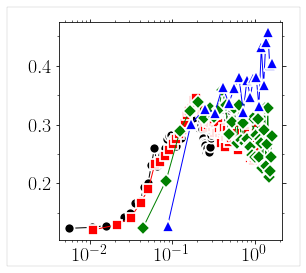

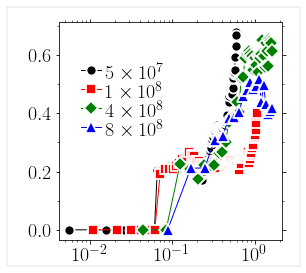

In [96]:
class MyPrint(Temperature):
    
    def __init__(self,temp_range,nrun,verbose=False):
        Temperature.__init__(self,temp_range,nrun,verbose)

    def Plot(self,col_x=1,col_y=1,mylegends='',**kwargs):
        symbols=Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs
                    else (1.0,0.5,0.5,0.5)
                   )

        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)

        for data, temp_run, count in zip(self.data,self.temps_runs,range(len(self.data))): 
            temp = temp_run[0]
            text = mylegends[count] if not mylegends == '' else ' '
            try:
                utl.PltErr(data[:,col_x],data[:,col_y],
#                        yerr=data[:,2],
                       ax = self.ax,
                       attrs=symbols.GetAttrs(count=count%7,nevery=1,label=r'%s'%text),
                       Plot=False,
                      )
            except:
                continue
        #
        attrs = {} if mylegends == '' else {'legend':legends.Get()}
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,
                   DrawFrame=DRAW_FRAME,
                   **attrs, #legend=legends.Get(),
                   **kwargs
                  )
        
def main():
    if eval(parser['flags']['RemoteMachine']):
        return
    
    !mkdir png
    #--- temp object
    myprint = MyPrint(
#       [4,1,2,3],1,
       [300,600,700,800,900],1,
#       [0],1,
         verbose = True,
                     )
    #
    #--- parse data
    myprint.Parse( 
#                ['avlStats/scatter_st.txt']
                list(map(lambda x:'tensileCantor_tensile900_rate%s/Run%s/dislocations/structureTypeFraction.txt'%(x[0],x[1]),
#                list(map(lambda x:'tensileCantorT%sKRateE3/Run%s/dislocations/structureTypeFraction.txt'%(x[0],x[1]),
                         myprint.temps_runs ))
              )
#     #
#     #--- plot
    myprint.Plot(col_x=1,col_y=2,**{
                    'xscale':'log',
#                    'ylim':(-0.05,1),
#                   'title':'png/rho_other_T900K_E1-4.png',
                   'title':'png/rho_other_T900K_E1-4.png',
    })

#     myprint.Plot(col_x=1,col_y=3,
#                  mylegends=[r'$5\times 10^{7}$',r'$1\times 10^{8}$',r'$4\times10^{8}$',r'$8\times10^{8}$'],
#                  **{
#                     'xlim':(0.0,0.1),
#                    'title':'png/rho_fcc_T900K_E1-4.png',
#                     'bbox_to_anchor':(0.5,0.5,0.5,0.5)}
#                 )
#
    myprint.Plot(col_x=1,col_y=4,
#                   mylegends=[r'$5\times 10^{7}$',r'$1\times 10^{8}$',r'$4\times10^{8}$',r'$8\times10^{8}$'],
                     mylegends=[r'$300$',r'$600$',r'$700$',r'$800$',r'$900$'],
                 **{
                    'xscale':'log',
                   'title':'png/rho_hcp_T900K_E1-4.png',
                     'bbox_to_anchor':(0.05,0.4,0.5,0.5)}
    )
#
#     myprint.Plot(col_x=1,col_y=5,**{
#                     'xlim':(0.0,0.1),
#                    'title':'png/rho_bcc_T900K_E1-4.png',
# #        'bbox_to_anchor':(0.5,0.01,0.5,0.5)
#     })


main()

mkdir: png: File exists
Parsing: data.shape is (12, 2)
Parsing: data.shape is (11, 2)
Parsing: data.shape is (4, 2)
Parsing: data.shape is (2, 2)


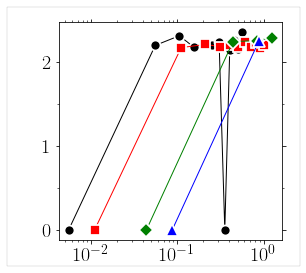

In [235]:
def main():
    if eval(parser['flags']['RemoteMachine']):
        return
    
    !mkdir png
    #--- temp object
    myprint = MyPrint(
       [4,1,2,3],1,
#       [300,600,700,800,900],1,
#       [0],1,
         verbose = True,
                     )
    #
    #--- parse data
    myprint.Parse( 
#                ['avlStats/scatter_st.txt']
                list(map(lambda x:'tensileCantor_tensile900_rate%s/Run%s/dislocations/fractalDimension.txt'%(x[0],x[1]),
#                list(map(lambda x:'tensileCantorT%sKRateE3/Run%s/dislocations/structureTypeFraction.txt'%(x[0],x[1]),
                         myprint.temps_runs ))
              )
#     #
     #--- plot

    myprint.Plot(col_x=0,col_y=1,
#                   mylegends=[r'$5\times 10^{7}$',r'$1\times 10^{8}$',r'$4\times10^{8}$',r'$8\times10^{8}$'],
#                     mylegends=[r'$300$',r'$600$',r'$700$',r'$800$',r'$900$'],
                 **{
                    'xscale':'log',
 #                  'title':'png/rho_hcp_T900K_E1-4.png',
                     'bbox_to_anchor':(0.05,0.4,0.5,0.5)}
    )


main()

In [179]:
# class Fractal:
#     '''
#     multi-fractal analysis of clusters
#     '''
#     def __init__(self, lmpDmin, lmpData, verbose = False):
#         '''
#         constructor
#         '''
#         self.lmpDmin = lmpDmin
#         self.lmpData = lmpData
#         self.verbose = verbose
        
#         !mkdir fractal
#         pass
    
#     def GetBitmaps(self,times, Plot=False):
#         '''
#         returns a binary matrix of clusters
#         '''
#         #--- loop over timesteps
#         for time in times:
#             #--- fetch data
#             dmin_log = np.log10(self.lmpDmin.coord_atoms_broken[time].d2min)
#             atom = lp.Atoms(**(self.lmpDmin.coord_atoms_broken[time]))
#             box  = lp.Box( BoxBounds = self.lmpData.BoxBounds[time],  AddMissing = np.array([0.0,0.0,0.0] ))
#             atom.NonaffineSquaredDisplacement = list(dmin_log)
#              #-----------------
#              #--- INTERPOLATE
#              #-----------------
#             (xlin, ylin, zlin), (xv, yv, zv), mu_intrp = utl.Intrp(atom, box, 'NonaffineSquaredDisplacement',
#                         Plot = None,
#                        )
#             #--- plot
#             value = utl.PltBinary(
#                                 xlin,ylin,zlin, mu_intrp.NonaffineSquaredDisplacement,
#                                 box,
#                                 0.0, #--- threshold
#                                 cmap='Greys',
#             #                    title='ModuAnl/negative_mu.%s.png'%itime,
#                                 zscore=False,
#                                 #DrawFrame=(0.21,0.06,0.15,0.06,0.1),
#                                 xlabel = 'x', ylabel = 'y',
#                                 labels = True,
#                                 Plot=Plot,
#                              )
#             if self.verbose:
#                 print('value.shape=',value.shape)

#             #---------------------
#             #--- output matrix
#             #---------------------
#             mask = value >= quantile(list(value.flatten()),0.95)
#             if self.verbose:
#                 print('p=',np.sum(mask)/value.size)
#             #--- save
#             np.save('fractal/negative_mu%s'%time,mask)
#             np.savetxt('fractal/xlin%s.txt'%time,np.c_[xlin,],header='xlin')
#             np.savetxt('fractal/ylin%s.txt'%time,np.c_[ylin,],header='ylin')
#             np.savetxt('fractal/zlin%s.txt'%time,np.c_[zlin,],header='zlin')
            
#     def Strain(self,itime0,itime):
#         #--- strain
#         box = lp.Box(BoxBounds=self.lmpData.BoxBounds[itime0],
#           AddMissing=np.array([0,0,0])
#           )

#         lz0 = box.CellVector[2,2]
#         return lp.Box(BoxBounds=lmpData.BoxBounds[itime],
#                           AddMissing=np.array([0,0,0])).CellVector[2,2]/lz0-1
               
        
    
#     def func(self,x, a, b):
#         return b * x ** a

#     def FractalDimension(self,pathh,times,Plot=False):
#         '''
#         returns fractal dimension df
#         '''
#         itime0 = np.min(list(self.lmpData.coord_atoms_broken.keys()))
#         times.sort()
#         Df = []
#         strain= []
#         for time in times:
#             stats = utl.Stats(mask=np.load('%s/negative_mu%s.npy'%(pathh,time)), 
#                              xlin=np.loadtxt('%s/xlin%s.txt'%(pathh,time)), 
#                              ylin=np.loadtxt('%s/ylin%s.txt'%(pathh,time)),
#                              zlin=np.loadtxt('%s/zlin%s.txt'%(pathh,time)),
#                             )
#             stats.GetSize()
#             stats.GetProbInf()
#             stats.GetProb()
#             stats.GetSmean()
#             stats.GetCrltnLenSq()
            
#             #--- fit
#             stats.stats.sort_values(by='rg_sq',inplace=True)
            
#             xdata = stats.stats['rg_sq']**0.5
#             ydata = stats.stats['size']
#             filtr = xdata > 0
# #             popt, pcov = curve_fit(self.func, xdata[filtr], ydata[filtr],
# #                                    bounds=((0,0),(np.inf,3))
# #                                   )
#             popt = np.polyfit(np.log10(xdata[filtr]), np.log10(ydata[filtr]),
#                                    1
#                                   )
#             popt[1] = 10 ** popt[1]
#             Df += [popt[0]]
#             if self.verbose:
#                 print('df=',popt[0])



#             #--- plot
#             if Plot:
#                 ax=utl.PltErr(xdata,ydata,
#                           attrs={'fmt':'.'},
#                               Plot=False,
#                           )
#                 utl.PltErr(xdata,self.func(xdata, *popt),
#                           attrs={'fmt':'r-.'},
#                           ax=ax,
#                            xscale='log',
#                            yscale='log',
#                            xstr=r'$r_g$',
#                            ystr=r'$s$',
#                            title='fractal/scatter_s_rg.png'
#                           )
                
#             strain += [self.Strain(itime0,time)]    
                
#         utl.PltErr(strain,Df,
#                   xstr=r'$\epsilon_{zz}$',
#                    ystr=r'$d_f$',
#                     title='fractal/df_strain.png'
#                   )

#     def GetStrsDrop(self,pathh,times):
#         '''
#         returns scatter data of stress drop and size
#         '''
#         sd=[]
#         volume=[]
#         for time in times:
#                 stats = utl.Stats(mask=np.load('%s/negative_mu%s.npy'%(pathh,time)), 
#                                  xlin=np.loadtxt('%s/xlin%s.txt'%(pathh,time)), 
#                                  ylin=np.loadtxt('%s/ylin%s.txt'%(pathh,time)),
#                                  zlin=np.loadtxt('%s/zlin%s.txt'%(pathh,time)),
#                                 )
#                 stats.GetSize()
#                 stats.GetProbInf()
#                 stats.GetProb()
#                 stats.GetSmean()
#                 stats.GetCrltnLenSq()

#                 vol  = lp.Box( BoxBounds = self.lmpData.BoxBounds[time],  
#                               AddMissing = np.array([0.0,0.0,0.0] )).GetVolume()

                
#                 sd += [vol*df_avl[df_avl['tf'] == time].iloc[0]['size']] #--- stress drop*vol
#                 volume += [stats.stats['size'].sum()]
#         #--- plot
#         ax=utl.PltErr(volume,sd,
#                   attrs={'fmt':'.'},
#                       Plot=False,
#                   )
#         utl.PltErr(None,None,#volume,volume,
#                   attrs={'fmt':'r-.'},
#                   ax=ax,
#                    xscale='log',
#                    yscale='log',
#                        ystr=r'$\Delta\sigma$',
#                        xstr=r'$s$',
# #                   xlim=(10**np.floor(np.log10(np.min(volume))),10**np.ceil(np.log10(np.min(volume))))
#                   )
    
# def main():
    
# # fractal = Fractal(lmpDmin, lmpData, verbose = True)
# # # fractal.GetBitmaps(
# # #                     [280000],#list(lmpDmin.coord_atoms_broken.keys())[0:1],
# # #                     Plot=True)
# # fractal.FractalDimension('cantor/rate2nd/Run2/fractal',
# #                          [280000],#list(lmpDmin.coord_atoms_broken.keys()),
# #                          Plot=False,
# #                         )
# # # fractal.GetStrsDrop('cantor/rate2nd/Run2/fractal',
# # #                     list(lmpDmin.coord_atoms_broken.keys())
# # #                    )

# main


# cluster analysis
+ cluster analysis of top 5% atoms with largest D2min values 

In [178]:
class Fractal:
    '''
    multi-fractal analysis of clusters
    '''
    
    def __init__(self,path,verbose=False):
        self.path = path
        self.verbose = verbose

    def Parse(self):
        list_dir = os.listdir(self.path)
        self.data=list(map(lambda x:json.load(open('%s/%s'%(self.path,x),'r')),list_dir))
        if self.verbose:
            list(map(lambda x:print('Parsing: data.shape is',x.keys()),self.data))


    def FracDimension(self,fout):
        self.dim = list(map(lambda x:self.ClusterAnalysis(x),self.data))
        strain = Fractal.Strain('./dislocations/mydislocations/mydislocations.xyz')
        #
        with open(fout,'w') as fp:
            np.savetxt(fp,np.c_[strain,self.dim],header='ezz df')
        
    def ClusterAnalysis(self,dictionary,Plot=False):
        '''
        returns fractal dimension df
        '''
        #--- reshape
        xlin, ylin, zlin, mask = Fractal.Reshape(dictionary)

        #--- cluster analysis
        stats = utl.Stats(mask, 
                         xlin, 
                         ylin,
                         zlin,
                        )
        stats.GetSize()
        stats.GetProbInf()
        stats.GetProb()
        stats.GetSmean()
        stats.GetCrltnLenSq()

        stats.stats.sort_values(by='rg_sq',inplace=True)
        df = 0
        try:
            df = Fractal.Get_Df(stats.stats)
        except:
            pass
        return df

#     def GetStrsDrop(self,pathh,times):
#         '''
#         returns scatter data of stress drop and size
#         '''
#         sd=[]
#         volume=[]
#         for time in times:
#                 stats = utl.Stats(mask=np.load('%s/negative_mu%s.npy'%(pathh,time)), 
#                                  xlin=np.loadtxt('%s/xlin%s.txt'%(pathh,time)), 
#                                  ylin=np.loadtxt('%s/ylin%s.txt'%(pathh,time)),
#                                  zlin=np.loadtxt('%s/zlin%s.txt'%(pathh,time)),
#                                 )
#                 stats.GetSize()
#                 stats.GetProbInf()
#                 stats.GetProb()
#                 stats.GetSmean()
#                 stats.GetCrltnLenSq()

#                 vol  = lp.Box( BoxBounds = self.lmpData.BoxBounds[time],  
#                               AddMissing = np.array([0.0,0.0,0.0] )).GetVolume()

                
#                 sd += [vol*df_avl[df_avl['tf'] == time].iloc[0]['size']] #--- stress drop*vol
#                 volume += [stats.stats['size'].sum()]
#         #--- plot
#         ax=utl.PltErr(volume,sd,
#                   attrs={'fmt':'.'},
#                       Plot=False,
#                   )
#         utl.PltErr(None,None,#volume,volume,
#                   attrs={'fmt':'r-.'},
#                   ax=ax,
#                    xscale='log',
#                    yscale='log',
#                        ystr=r'$\Delta\sigma$',
#                        xstr=r'$s$',
# #                   xlim=(10**np.floor(np.log10(np.min(volume))),10**np.ceil(np.log10(np.min(volume))))
#                   )
    @staticmethod
    def Reshape(d):
        nx = len(d['x'])
        ny = len(d['y'])
        nz = len(d['z'])
        val = np.array(d['val']).reshape(ny,nx,nz)
        return d['x'], d['y'], d['z'], val
    
    @staticmethod
    def Get_Df(data_frame):
        #--- fit

        xdata = data_frame['rg_sq']**0.5
        ydata = data_frame['size']
        filtr = xdata > 0
        popt, pcov = curve_fit(Fractal.func, xdata[filtr], ydata[filtr],
                               bounds=((0,0),(np.inf,3))
                              )
        popt = np.polyfit(np.log10(xdata[filtr]), np.log10(ydata[filtr]),
                               1
                              )
        return popt[0]
    
    @staticmethod
    def func(x, a, b):
        return b * x ** a

    @staticmethod
    def Strain(fp):
        lmpData = lp.ReadDumpFile('%s'%(fp)) #,verbose=self.verbose)
        lmpData.GetCords(ncount=sys.maxsize)
        return Defects.Strain(lmpData)

def main():    
    fractal = Fractal('./dislocations/BinaryMatrix',
#                      verbose=True
                     )
    #--- parse data
    fractal.Parse()

    #--- statistics of clusters
    fractal.FracDimension(fout='./dislocations/fractalDimension.txt')
    
    # fractal.GetStrsDrop('cantor/rate2nd/Run2/fractal',
    #                     list(lmpDmin.coord_atoms_broken.keys())
    #                    )


main()


mkdir: png: File exists
Parsing: data.shape is dict_keys(['x', 'y', 'z', 'val', 'timestep'])
Parsing: data.shape is dict_keys(['x', 'y', 'z', 'val', 'timestep'])


In [21]:
# class Fractal:
#     '''
#     multi-fractal analysis of clusters
#     '''
#     def __init__(self, lmpDmin, lmpData, verbose = False):
#         '''
#         constructor
#         '''
#         self.lmpDmin = lmpDmin
#         self.lmpData = lmpData
#         self.verbose = verbose
        
#         !mkdir fractal
#         pass
    
#     def GetBitmaps(self,times, Plot=False):
#         '''
#         returns a binary matrix of clusters
#         '''
#         #--- loop over timesteps
#         for time in times:
#             #--- fetch data
#             dmin_log = np.log10(self.lmpDmin.coord_atoms_broken[time].d2min)
#             atom = lp.Atoms(**(self.lmpDmin.coord_atoms_broken[time]))
#             box  = lp.Box( BoxBounds = self.lmpData.BoxBounds[time],  AddMissing = np.array([0.0,0.0,0.0] ))
#             atom.NonaffineSquaredDisplacement = list(dmin_log)
#              #-----------------
#              #--- INTERPOLATE
#              #-----------------
#             (xlin, ylin, zlin), (xv, yv, zv), mu_intrp = utl.Intrp(atom, box, 'NonaffineSquaredDisplacement',
#                         Plot = None,
#                        )
#             #--- plot
#             value = utl.PltBinary(
#                                 xlin,ylin,zlin, mu_intrp.NonaffineSquaredDisplacement,
#                                 box,
#                                 0.0, #--- threshold
#                                 cmap='Greys',
#             #                    title='ModuAnl/negative_mu.%s.png'%itime,
#                                 zscore=False,
#                                 #DrawFrame=(0.21,0.06,0.15,0.06,0.1),
#                                 xlabel = 'x', ylabel = 'y',
#                                 labels = True,
#                                 Plot=Plot,
#                              )
#             if self.verbose:
#                 print('value.shape=',value.shape)

#             #---------------------
#             #--- output matrix
#             #---------------------
#             mask = value >= quantile(list(value.flatten()),0.95)
#             if self.verbose:
#                 print('p=',np.sum(mask)/value.size)
#             #--- save
#             np.save('fractal/negative_mu%s'%time,mask)
#             np.savetxt('fractal/xlin%s.txt'%time,np.c_[xlin,],header='xlin')
#             np.savetxt('fractal/ylin%s.txt'%time,np.c_[ylin,],header='ylin')
#             np.savetxt('fractal/zlin%s.txt'%time,np.c_[zlin,],header='zlin')
            
#     def Strain(self,itime0,itime):
#         #--- strain
#         box = lp.Box(BoxBounds=self.lmpData.BoxBounds[itime0],
#           AddMissing=np.array([0,0,0])
#           )

#         lz0 = box.CellVector[2,2]
#         return lp.Box(BoxBounds=lmpData.BoxBounds[itime],
#                           AddMissing=np.array([0,0,0])).CellVector[2,2]/lz0-1
               
        
    
#     def func(self,x, a, b):
#         return b * x ** a

#     def FractalDimension(self,pathh,times,Plot=False):
#         '''
#         returns fractal dimension df
#         '''
#         itime0 = np.min(list(self.lmpData.coord_atoms_broken.keys()))
#         times.sort()
#         Df = []
#         strain= []
#         for time in times:
#             stats = utl.Stats(mask=np.load('%s/negative_mu%s.npy'%(pathh,time)), 
#                              xlin=np.loadtxt('%s/xlin%s.txt'%(pathh,time)), 
#                              ylin=np.loadtxt('%s/ylin%s.txt'%(pathh,time)),
#                              zlin=np.loadtxt('%s/zlin%s.txt'%(pathh,time)),
#                             )
#             stats.GetSize()
#             stats.GetProbInf()
#             stats.GetProb()
#             stats.GetSmean()
#             stats.GetCrltnLenSq()
            
#             #--- fit
#             stats.stats.sort_values(by='rg_sq',inplace=True)
            
#             xdata = stats.stats['rg_sq']**0.5
#             ydata = stats.stats['size']
#             filtr = xdata > 0
# #             popt, pcov = curve_fit(self.func, xdata[filtr], ydata[filtr],
# #                                    bounds=((0,0),(np.inf,3))
# #                                   )
#             popt = np.polyfit(np.log10(xdata[filtr]), np.log10(ydata[filtr]),
#                                    1
#                                   )
#             popt[1] = 10 ** popt[1]
#             Df += [popt[0]]
#             if self.verbose:
#                 print('df=',popt[0])



#             #--- plot
#             if Plot:
#                 ax=utl.PltErr(xdata,ydata,
#                           attrs={'fmt':'.'},
#                               Plot=False,
#                           )
#                 utl.PltErr(xdata,self.func(xdata, *popt),
#                           attrs={'fmt':'r-.'},
#                           ax=ax,
#                            xscale='log',
#                            yscale='log',
#                            xstr=r'$r_g$',
#                            ystr=r'$s$',
#                            title='fractal/scatter_s_rg.png'
#                           )
                
#             strain += [self.Strain(itime0,time)]    
                
#         utl.PltErr(strain,Df,
#                   xstr=r'$\epsilon_{zz}$',
#                    ystr=r'$d_f$',
#                     title='fractal/df_strain.png'
#                   )

#     def GetStrsDrop(self,pathh,times):
#         '''
#         returns scatter data of stress drop and size
#         '''
#         sd=[]
#         volume=[]
#         for time in times:
#                 stats = utl.Stats(mask=np.load('%s/negative_mu%s.npy'%(pathh,time)), 
#                                  xlin=np.loadtxt('%s/xlin%s.txt'%(pathh,time)), 
#                                  ylin=np.loadtxt('%s/ylin%s.txt'%(pathh,time)),
#                                  zlin=np.loadtxt('%s/zlin%s.txt'%(pathh,time)),
#                                 )
#                 stats.GetSize()
#                 stats.GetProbInf()
#                 stats.GetProb()
#                 stats.GetSmean()
#                 stats.GetCrltnLenSq()

#                 vol  = lp.Box( BoxBounds = self.lmpData.BoxBounds[time],  
#                               AddMissing = np.array([0.0,0.0,0.0] )).GetVolume()

                
#                 sd += [vol*df_avl[df_avl['tf'] == time].iloc[0]['size']] #--- stress drop*vol
#                 volume += [stats.stats['size'].sum()]
#         #--- plot
#         ax=utl.PltErr(volume,sd,
#                   attrs={'fmt':'.'},
#                       Plot=False,
#                   )
#         utl.PltErr(None,None,#volume,volume,
#                   attrs={'fmt':'r-.'},
#                   ax=ax,
#                    xscale='log',
#                    yscale='log',
#                        ystr=r'$\Delta\sigma$',
#                        xstr=r'$s$',
# #                   xlim=(10**np.floor(np.log10(np.min(volume))),10**np.ceil(np.log10(np.min(volume))))
#                   )
    
# def main():
    
# # fractal = Fractal(lmpDmin, lmpData, verbose = True)
# # # fractal.GetBitmaps(
# # #                     [280000],#list(lmpDmin.coord_atoms_broken.keys())[0:1],
# # #                     Plot=True)
# # fractal.FractalDimension('cantor/rate2nd/Run2/fractal',
# #                          [280000],#list(lmpDmin.coord_atoms_broken.keys()),
# #                          Plot=False,
# #                         )
# # # fractal.GetStrsDrop('cantor/rate2nd/Run2/fractal',
# # #                     list(lmpDmin.coord_atoms_broken.keys())
# # #                    )

# main


In [ ]:
# fractal = Fractal(lmpDmin, lmpData, verbose = True)
# # fractal.GetBitmaps(
# #                     [280000],#list(lmpDmin.coord_atoms_broken.keys())[0:1],
# #                     Plot=True)
# fractal.FractalDimension('cantor/rate2nd/Run2/fractal',
#                          [280000],#list(lmpDmin.coord_atoms_broken.keys()),
#                          Plot=False,
#                         )
# # fractal.GetStrsDrop('cantor/rate2nd/Run2/fractal',
# #                     list(lmpDmin.coord_atoms_broken.keys())
# #                    )


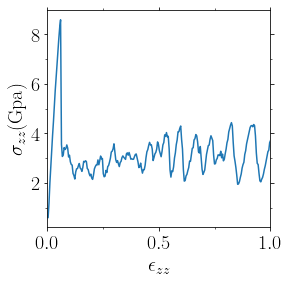

<AxesSubplot:xlabel='$\\epsilon_{zz}$', ylabel='$\\sigma_{zz}(\\mathrm{Gpa})$'>

In [7]:
# #--- timesteps
# keys = list(lmpData.coord_atoms_broken.keys())
# keys.sort()

# #--- stress
# szz = list(map(lambda x:lmpData.coord_atoms_broken[x]['c_mystress[3]'].sum(),keys))

# #--- strain
# box = lp.Box(BoxBounds=lmpData.BoxBounds[keys[0]],
#       AddMissing=np.array([0,0,0])
#       )

# lz0 = box.CellVector[2,2]
# ezz = list(map(lambda x:lp.Box(BoxBounds=lmpData.BoxBounds[x],AddMissing=np.array([0,0,0])).CellVector[2,2]/lz0-1,
#                keys))

# #--- volume
# vol = list(map(lambda x:np.linalg.det(lp.Box(BoxBounds=lmpData.BoxBounds[x],AddMissing=np.array([0,0,0])).CellVector),
#                keys))

# dmpStrs=pd.DataFrame(np.c_[keys,np.array(ezz+ezz[1]-ezz[0]),1e-4*np.array(szz)/vol],columns=['timestep','strain','szz'])

# #--- plot
# symbols=Symbols()
# ax=utl.PltErr(None,#loadTimeSeries['strain'],
#           None,#loadTimeSeries['szz'],
#            fmt='-',
#               Plot=False,
          
#           )
# utl.PltErr(dmpStrs.strain,dmpStrs.szz,
# #            attrs=symbols.GetAttrs(count=0,fmt='.-'),
#            attrs={'fmt':'-','color':'C0'},
#           ax=ax,
#             xlim=(0.0,1.0),
# #            ylim=(2,3)
#            xstr=r'$\epsilon_{zz}$',
#            ystr=r'$\sigma_{zz}(\mathrm{Gpa})$',
#            title='png/stress_strain.png'
#           )



### strain map

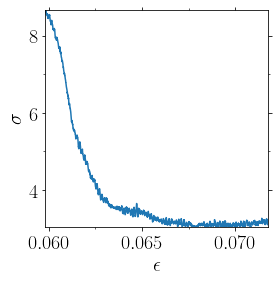

<AxesSubplot:xlabel='$\\epsilon$', ylabel='$\\sigma$'>

In [10]:
# #--- strain window
# tif=df_avl.iloc[0][['ei','ef']]
# filtr=np.all([dmpStrs['strain']<tif['ef'],dmpStrs['strain']>=tif['ei']],axis=0)
# # #--- load
# flo = 0.99*dmpStrs['szz'][filtr].min()
# fhi = 1.01*dmpStrs['szz'][filtr].max() #ld.Force.max()

# #--- load vs. time
# ydata = loadTimeSeries
# utl.PltErr(ydata.strain, ydata.szz,
#            attrs={'fmt':'-'},
#             xlim=(tif['ei'],tif['ef']),
#             ylim=(flo,fhi),
#            xstr=r'$\epsilon$',
#            ystr=r'$\sigma$',
#           )

### local strain

In [11]:
# def WrapperStrain(lmpData,reference_frames,current_frames, dim=3):
#     '''
#     invoke strain analysis in ovito
#     '''
#     #--- split dump file
#     for ii0, ii in zip(reference_frames,current_frames):
#         atom_current = lp.Atoms(**lmpData.coord_atoms_broken[ii])
#         atom_reference = lp.Atoms(**lmpData.coord_atoms_broken[ii0])
#         box  = lp.Box( BoxBounds = lmpData.BoxBounds[ii],  AddMissing = np.array([0.0,0.0,0.0] ))
#         box0 = lp.Box( BoxBounds = lmpData.BoxBounds[ii0], AddMissing = np.array([0.0,0.0,0.0] ))
#         lp.WriteDumpFile(atom_current, box).Write('strain/dump_curr.xyz', itime = ii,
#                  attrs=['id', 'type','x', 'y', 'z'],
#                  fmt='%i %i %15.14e %15.14e %15.14e')

#         lp.WriteDumpFile(atom_reference, box0).Write('strain/dump_ref.xyz', itime=ii0,
#              attrs=['id', 'type','x', 'y', 'z'],
#              fmt='%i %i %15.14e %15.14e %15.14e')
#         fileCurr = 'strain/dump_curr.xyz'
#         fileRef = 'strain/dump_ref.xyz'
#         output = 'strain/d2min.%s.xyz'%ii
#         #--- load to ovito
#         os.system('ovitos %s/OvitosCna.py %s %s 2 5 %s'%(parser['py library directory']['path'],
#                                                          fileCurr,output,fileRef))
#         #--- concat
#         os.system('cat %s >> strain/strain.xyz;rm %s'%(output,output))

        
# !mkdir strain
# try:
#     os.system('rm strain/strain.xyz')
# except:
#     pass
# #--- current
# current_frames = np.c_[df_avl['tf']].astype(int).flatten()
# print('current_frames=',current_frames)
# #--- reference
# reference_frames = np.c_[[df_avl['ti']]].astype(int).flatten()
# print('reference_frames=',reference_frames)

# #--- call function
# WrapperStrain(lmpData,reference_frames,current_frames)

# #--- parse
# lmpStrn = lp.ReadDumpFile( 'strain/strain.xyz' )
# lmpStrn.GetCords( ncount = sys.maxsize )

mkdir: cannot create directory ‘strain’: File exists
current_frames= [ 280000 2770000 2250000 2500000 1650000 3340000 3720000 3420000 3650000
 1500000  410000 1990000 3050000 1860000 3930000  750000  910000  610000
 1810000 1300000 2970000 1140000 1380000 2910000 2090000 1180000  490000
 1070000  980000 1010000 2410000 3580000  310000 2040000  690000]
reference_frames= [ 250000 2660000 2170000 2430000 1600000 3270000 3660000 3370000 3600000
 1440000  330000 1950000 3010000 1820000 3890000  710000  850000  540000
 1780000 1260000 2930000 1100000 1350000 2880000 2050000 1150000  460000
 1020000  960000 1000000 2400000 3570000  300000 2030000  680000]
InputFile= strain/dump_curr.xyz
OutputFile= strain/d2min.280000.xyz
nevery 2
InputFile= strain/dump_curr.xyz
num_frames= 1
frame=0/1
InputFile= strain/dump_curr.xyz
OutputFile= strain/d2min.2770000.xyz
nevery 2
InputFile= strain/dump_curr.xyz
num_frames= 1
frame=0/1
InputFile= strain/dump_curr.xyz
OutputFile= strain/d2min.2250000.xyz
nevery 

### d2min

In [12]:
# def WrapperD2min(lmpData,reference_frames,current_frames, dim=3):
#     '''
#     invoke d2min analysis in ovito
#     '''
#     #--- split dump file
#     for ii0, ii in zip(reference_frames,current_frames):
#         atom_current = lp.Atoms(**lmpData.coord_atoms_broken[ii])
#         atom_reference = lp.Atoms(**lmpData.coord_atoms_broken[ii0])
#         box  = lp.Box( BoxBounds = lmpData.BoxBounds[ii],  AddMissing = np.array([0.0,0.0,0.0] ))
#         box0 = lp.Box( BoxBounds = lmpData.BoxBounds[ii0], AddMissing = np.array([0.0,0.0,0.0] ))
#         if dim == 3:
#             lp.WriteDumpFile(atom_current, box).Write('D2minAnl/dump_curr.xyz', itime = ii,
#                  attrs=['id', 'type','x', 'y', 'z'],
#                  fmt='%i %i %15.14e %15.14e %15.14e')
#             lp.WriteDumpFile(atom_reference, box0).Write('D2minAnl/dump_ref.xyz', itime=ii0,
#                  attrs=['id', 'type','x', 'y', 'z'],
#                  fmt='%i %i %15.14e %15.14e %15.14e')
#         else:
#             lp.WriteDumpFile(atom_current, box).Write('D2minAnl/dump_curr.xyz', itime = ii,
#                  attrs=['id', 'type','x', 'y'],
#                  fmt='%i %i %15.14e %15.14e')
#             lp.WriteDumpFile(atom_reference, box0).Write('D2minAnl/dump_ref.xyz', itime=ii0,
#                  attrs=['id', 'type','x', 'y'],
#                  fmt='%i %i %15.14e %15.14e')
#     #    os.system('tar czf dump.gz dump.xyz')
#         fileCurr = 'D2minAnl/dump_curr.xyz'
#         fileRef = 'D2minAnl/dump_ref.xyz'
#         output = 'D2minAnl/d2min.%s.xyz'%ii
#         #--- load to ovito
#         os.system('ovitos %s/OvitosCna.py %s %s 2 2 %s'%(parser['py library directory']['path'],
#                                                          fileCurr,output,fileRef))
#         #--- concat
#         os.system('cat %s >> D2minAnl/d2min.xyz;rm %s'%(output,output))

        
        
        
# #    assert nevery < len(lmpData.coord_atoms_broken.keys()), 'decrease nevery!'
# !mkdir D2minAnl
# try:
#     os.system('rm D2minAnl/d2min.xyz')
# except:
#     pass

# #--- assign frames
# #--- current
# current_frames = np.c_[df_avl['tf']].astype(int).flatten()
# print('current_frames=',current_frames)
# #--- reference
# reference_frames = np.c_[[df_avl['ti']]].astype(int).flatten()
# print('reference_frames=',reference_frames)

# #--- call function
# WrapperD2min(lmpData,reference_frames,current_frames)
# #--- parse
# lmpDmin = lp.ReadDumpFile( 'D2minAnl/d2min.xyz' )
# lmpDmin.GetCords( ncount = sys.maxsize, columns = {'NonaffineSquaredDisplacement':'d2min'} )

mkdir: cannot create directory ‘D2minAnl’: File exists
current_frames= [ 280000 2770000 2250000 2500000 1650000 3340000 3720000 3420000 3650000
 1500000  410000 1990000 3050000 1860000 3930000  750000  910000  610000
 1810000 1300000 2970000 1140000 1380000 2910000 2090000 1180000  490000
 1070000  980000 1010000 2410000 3580000  310000 2040000  690000]
reference_frames= [ 250000 2660000 2170000 2430000 1600000 3270000 3660000 3370000 3600000
 1440000  330000 1950000 3010000 1820000 3890000  710000  850000  540000
 1780000 1260000 2930000 1100000 1350000 2880000 2050000 1150000  460000
 1020000  960000 1000000 2400000 3570000  300000 2030000  680000]
InputFile= D2minAnl/dump_curr.xyz
OutputFile= D2minAnl/d2min.280000.xyz
nevery 2
InputFile= D2minAnl/dump_curr.xyz
num_frames= 1
frame=0/1
InputFile= D2minAnl/dump_curr.xyz
OutputFile= D2minAnl/d2min.2770000.xyz
nevery 2
InputFile= D2minAnl/dump_curr.xyz
num_frames= 1
frame=0/1
InputFile= D2minAnl/dump_curr.xyz
OutputFile= D2minAnl/d2min.2

### plot

In [13]:
# def quantile(slist,q):
#     slist.sort()
#     n=len(slist)
#     return slist[int(q*n):][0]


# #--- print 
# !rm D2minAnl/d2min_avalanche.xyz
# keys=list(lmpDmin.coord_atoms_broken.keys())
# keys.sort()
# sfile=open('D2minAnl/d2min_avalanche.xyz','a')
# for time in keys:
#     dmin_log = np.log10(lmpDmin.coord_atoms_broken[time].d2min)
#     filtr = dmin_log >= quantile(list(dmin_log),0.95)
#     atom = lp.Atoms(**(lmpDmin.coord_atoms_broken[time][filtr]))
#     box  = lp.Box( BoxBounds = lmpData.BoxBounds[time],  AddMissing = np.array([0.0,0.0,0.0] ))
#     atom.NonaffineSquaredDisplacement = list(dmin_log[filtr])
        
#     #
#     lp.WriteDumpFile(atom, box).Write(sfile, itime = time,
#          attrs=['id', 'type','x', 'y', 'z','NonaffineSquaredDisplacement'],
#          fmt='%i %i %f %f %f %f')
# sfile.close()

### vary threshold

# of avalanches:726
# of avalanches:726
# of avalanches:728
# of avalanches:728
# of avalanches:718
# of avalanches:391


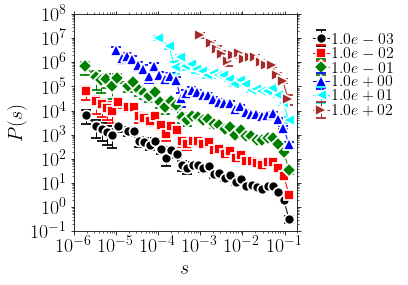

<AxesSubplot:xlabel='$s$', ylabel='$P(s)$'>

In [186]:
# def varyThreshold(loadTimeSeries, tlo, thi, lambdc):
#     return np.concatenate(list(map(lambda x:Wrapper_GetAvl(x,tlo,thi,lambdc)['size'], loadTimeSeries)))

# legend=Legends()
# legend.Set(fontsize=16,
#                  labelspacing=0,
#                  bbox_to_anchor=(1,0.48,0.5,0.5),
#            )
# #
# alpha=1.0
# #
# lambdc = np.logspace(np.log10(1.0e-3),np.log10(1.0e2),6)
# size_lambdc = list(map(lambda x:varyThreshold([loadTimeSeries[0]], tlo, thi, x),lambdc))

# #--- distributions
# hists = list(map(lambda x: utl.GetPDF(x, n_per_decade=8, linscale=None), size_lambdc))

# ax = utl.PltErr(None,None,Plot=False)
# for item, threshold, indx in zip(hists, lambdc, range(len(hists))):
#     hist, edge, err = item
#     ax=utl.PltErr(edge, 
#                   10**indx*hist,#*edge**alpha, 
#                   yerr=10**indx*err,#*edge**alpha,
#                    attrs=symbols.GetAttrs(count=indx%7,label=r'$%2.1e$'%threshold),
#                     Plot = False,
#                     ax=ax,
#                   )
# utl.PltErr(None,None,
# #    edge, 1e-1/edge**alpha,
# #           attrs={'fmt':'-.r'},
#             legend=legend.Get(),
# #           ystr=r'$P(s).s^{%s}$'%alpha,xstr=r'$s$',
#            ystr=r'$P(s)$',xstr=r'$s$',
#            xscale = 'log',yscale='log',
#            xlim=(1.0e-6,.2),ylim=(1e-1,1e8), #hist.min(),hist.min()*1e8),
#            ax=ax,
#            title='png/ps.png',
#           )

[ 1.25007966 -0.53496973 12.76198166]


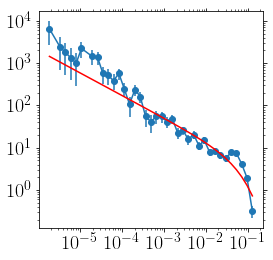

<AxesSubplot:>

In [170]:
# def func(x, a, b, c):
#     return a * x**b * np.exp(-c * x)
# def func2(x, a, b):
#     return a * x**b

# xdata = edge
# ydata = hist
# yerr=err
# ax = utl.PltErr(xdata, ydata, yerr=yerr, label='data',Plot=False)
# popt, pcov = curve_fit(func, xdata, ydata,
#                       bounds=((1e-3,-4,1e-3), (np.infty, 0, 100.0)),
#                        p0=(1,-1,10.0),
#                        sigma=err,
#                       )
# print(popt)
# utl.PltErr(xdata, func(xdata, *popt), attrs={'fmt':'r-'},
#          label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt),
#         ax=ax,
#            xscale='log',yscale='log',
#           )



In [348]:
# input_file = '/Users/Home/Desktop/Tmp/txt/git/DislocationAvalanches/nanoindentation/ebsd/attributes.txt'
# grain_attr = pd.read_csv(input_file,sep='\t')
# grain_attr.head()

,#grainID,x,y,grainSize,perimeter,boundarySize,numNeighbors
0,1,-0.018954,0.068387,1,3.695012,5,1
1,2,-85.909030,-0.799994,1,2.771259,6,1
2,3,-85.909030,-2.399981,1,2.771259,6,2
3,4,-141.335700,-0.852774,10,13.056300,24,3
4,5,-85.909030,-3.199974,1,2.771259,6,3


In [349]:
# def Wrapper(index):
#     #index = 0 #--- file index
#     ld = loadTimeSeries[ index ] #--- file id
#     indentLabel = indentLabels[index]

#     grainLabel = grainLabels[loadID][indentLabel]
#     print('indent label:%s, grain label:%s'%(indentLabel,grainLabel))

#     lambdc = 10.0
#     avlanche = Wrapper_GetAvl(ld,tlo,thi,lambdc)
#     moment_1st = np.mean(avlanche)
#     avalanche_sq = avlanche*avlanche
#     moment_2nd = np.mean(avalanche_sq)**0.5
#     avalanche_4th = avalanche_sq*avalanche_sq
#     moment_4th = np.mean(avalanche_4th)**0.25

#     grainSize = grain_attr[ grain_attr['#grainID'] == grainLabel ].grainSize
# #    pdb.set_trace()
#     return grainSize.iloc[0], moment_1st, moment_2nd, moment_4th


# #val = np.c_[list(map(lambda x:Wrapper(x),range(len(loadTimeSeries))))]
# # utl.PltErr(utl.Zscore(val[:,0]),utl.Zscore(val[:,1]),
# #           attrs={'fmt' : '.',
# #           'markersize':10.0},
# #             xstr=r'grain size',
# #             ystr=r'1st moment',
# #            xlim=(-3,3),
# #            ylim=(-3,3),
# #           )

# # utl.PltErr(utl.Zscore(val[:,0]),utl.Zscore(val[:,2]),
# #           attrs={'fmt' : '.',
# #           'markersize':10.0},
# #             xstr=r'grain size',
# #             ystr=r'2nd moment',
# #            xlim=(-3,3),
# #            ylim=(-3,3),
# #           )
# # utl.PltErr(val[:,0],val[:,2],
# #           attrs={'fmt' : '.',
# #           'markersize':10.0},
# #             xstr=r'grain size',
# #             ystr=r'avalanche size(2nd moment)',
# #            title='avalancheSize.png'
# # #           xlim=(-3,3),
# # #           ylim=(-3,3),
# #           )

# # utl.PltErr(utl.Zscore(val[:,0]),utl.Zscore(val[:,3]),
# #           attrs={'fmt' : '.',
# #           'markersize':10.0},
# #             xstr=r'grain size',
# #             ystr=r'4th moment',
# #            xlim=(-3,3),
# #            ylim=(-3,3),
# #           )


mkdir: cannot create directory ‘fractal’: File exists
df= 1.9587480814301905


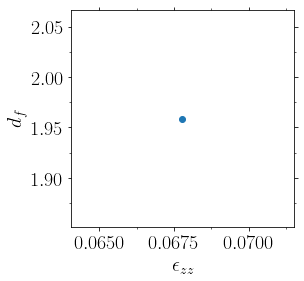

In [63]:
# df = pd.DataFrame(np.c_[xv.flatten(),yv.flatten(),zv.flatten(),mask.flatten()],columns=['x','y','z','mass'])
# utl.PrintOvito( df,
#                open('ovito.xyz','w'),
#                'itime=0',
#                 attr_list=['x', 'y', 'z','mass'],

#             )

In [64]:
#     sfile=open('dump.xyz','w')
#     dmin_log = np.log10(lmpDmin.coord_atoms_broken[time].d2min)
#     filtr = dmin_log >= quantile(list(dmin_log),0.95)
#     atom = lp.Atoms(**(lmpDmin.coord_atoms_broken[time][filtr]))
#     box  = lp.Box( BoxBounds = lmpData.BoxBounds[time],  AddMissing = np.array([0.0,0.0,0.0] ))
#     atom.NonaffineSquaredDisplacement = list(dmin_log[filtr])
        
#     #
#     lp.WriteDumpFile(atom, box).Write(sfile, itime = time,
#          attrs=['id', 'type','x', 'y', 'z','NonaffineSquaredDisplacement'],
#          fmt='%i %i %f %f %f %f')
#     sfile.close()